# MOM6 work rate (W)

### $W = g\rho_0 \bigl< \textbf{U} \cdot \nabla (\eta_{eq} + \eta_{SAL}) \bigr>$

#### In spherical coordinate, the gradient is calculated as 

$\nabla\mathbf{\eta} = \frac{\partial \eta}{\partial r} \hat{r} + \frac{1}{r} \frac{\partial \eta}{\partial \theta} \hat{\theta} + \frac{1}{r \text{sin}(\theta)} \frac{\partial \eta}{\partial \phi} \hat{\phi}$

#### $\textbf{U} = 0\cdot \hat{r} - vH \cdot \hat{\theta} + uH \cdot \hat{\phi}$

#### $\textbf{U} \cdot \nabla \eta = - \frac{vH}{r} \frac{\partial \eta}{\partial \theta} + \frac{uH}{r\text{sin}(\theta)} \frac{\partial \eta}{\partial \phi}$

#### $\theta = \frac{\pi}{2} - \text{lat}$, $\phi=\text{lon}$

#### $\textbf{U} \cdot \nabla \eta = \frac{vH}{r} \frac{\partial \eta}{\partial \text{lat}} + \frac{uH}{r\text{cos}(\text{lat})} \frac{\partial \eta}{\partial \text{lon}}$

#### $W = g\rho_0 \bigl< \frac{vH}{r} \frac{\partial \eta}{\partial \text{lat}} + \frac{uH}{r\text{cos}(\text{lat})} \frac{\partial \eta}{\partial \text{lon}} \bigr>$

#### Area of the grid cell $dS =  r^2 \sin \theta \, d\theta \, d\phi$

#### $dS =  -r^2 \cos (\text{lat}) \, d(\text{lat}) \, d(\text{lon})$

In [17]:
%matplotlib inline
import time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

In [2]:
g = 9.8
nt = 236
rho0 = 1035.0
radius = 6371e+3
t_19cyc = np.arange(nt)

In [3]:
file_stat = '/scratch/nm03/lxy581/mom6/archive/tides_008_global_sigma_SAL_x05/output002/ocean_static.nc'
stat  = xr.open_dataset(file_stat)
depth_008  = stat['deptho']
geolat_008 = stat['geolat']
geolon_008 = stat['geolon']
area_008 = stat['areacello']
fac_dep_008 = xr.where(depth_008 > 1000, 1, np.nan) 
fac_lat_008 = xr.where((geolat_008 < 66) & (geolat_008 > -66), 1, np.nan)
fac_008 = np.array(fac_dep_008) * np.array(fac_lat_008)

In [4]:
mask_ocean = depth_008 > 0

In [5]:
print(depth_008.max().values)

6500.0


In [6]:
lon_z = np.array(stat.geolon)/180 *np.pi
lat_z = np.array(stat.geolat)/180 *np.pi
lon_u = np.array(stat.geolon_u)/180 *np.pi
lat_u = np.array(stat.geolat_u)/180 *np.pi
lon_v = np.array(stat.geolon_v)/180 *np.pi
lat_v = np.array(stat.geolat_v)/180 *np.pi

### Construct $\eta_{eq}$ and $\eta_{sal}$

In [7]:
d = xr.open_dataset('/scratch/nm03/lxy581/mom6/archive/tides_008_global_sigma_SAL_x05/output002/ocean_interior.nc')

time_len = 236

# chunking could probably use some tweaking, mainly to ensure we don't run out of memory on small ARE jobs
elev = d.e.isel(zi=0, time=slice(None, time_len))
elev["time"] = np.arange(len(elev.time)) + 20*24

eta_eq = d.e_tide_eq.isel(time=slice(None, time_len))
eta_eq["time"] = np.arange(len(eta_eq.time)) + 20*24

eta_sal = d.e_sal.isel(time=slice(None, time_len))
eta_sal["time"] = np.arange(len(eta_sal.time)) + 20*24

In [8]:
eta = np.array(eta_sal) + np.array(eta_eq)

In [9]:
print(elev.shape)
print(eta.shape)

(236, 3270, 4320)
(236, 3270, 4320)


In [10]:
print(np.nanmin(elev))
print(np.nanmax(elev))
print(np.nanmin(eta))
print(np.nanmax(eta))

-4.5081
5.0340796
-0.21225502
0.21218033


In [11]:
u = d.uo.isel(zl=0, time=slice(None, time_len))
u["time"] = np.arange(len(u.time)) + 20*24

v = d.vo.isel(zl=0, time=slice(None, time_len))
v["time"] = np.arange(len(v.time)) + 20*24

In [13]:
deta_dlat = (eta[:,1:,:] - eta[:,:-1,:]) / (lat_z[1:,:] - lat_z[:-1,:])[None, :, :]
deta_dlon = (eta[:,:,1:] - eta[:,:,:-1]) / (lon_z[:,1:] - lon_z[:,:-1])[None, :, :]

In [14]:
grad_the = np.nanmean(v[:,1:-1,:]*deta_dlat/radius, axis=0) 

In [15]:
grad_phi = np.nanmean(u[:,:,1:-1]*deta_dlon/(radius*np.cos(lat_u[None,:,1:-1])), axis=0) 

In [18]:
weights_base = Path("/g/data/nm03/lxy581/archive/tides_008_global_sigma_SAL_x05/output002")
weights_u = weights_base / "u2h_weights.nc"
weights_v = weights_base / "v2h_weights.nc"

In [20]:
start_time = time.time()

ds_grad_the = xr.Dataset(data_vars={"grad_the": (('ny','nx'), grad_the),
                                },
                      coords={"lon": (('ny', 'nx'), lon_v[1:-1,:]), 
                              "lat": (('ny', 'nx'), lat_v[1:-1,:])})

ds_grad_phi = xr.Dataset(data_vars={"grad_phi": (('ny','nx'), grad_phi),
                                },
                      coords={"lon": (('ny', 'nx'), lon_u[:,1:-1]), 
                              "lat": (('ny', 'nx'), lat_u[:,1:-1])})

ds_grid_z = xr.Dataset({"lat": (["ny","nx"], lat_z),
                        "lon": (["ny","nx"], lon_z)})

regridder_grad_the_2z = xe.Regridder(ds_grad_the, ds_grid_z, "bilinear", extrap_method="inverse_dist")
regridder_grad_phi_2z = xe.Regridder(ds_grad_phi, ds_grid_z, "bilinear", extrap_method="inverse_dist")#, reuse_weights=True, weights=weights_v)

ds_grad_the_z = regridder_grad_the_2z(ds_grad_the)
ds_grad_phi_z = regridder_grad_phi_2z(ds_grad_phi)

grad_the_z = np.array(ds_grad_the_z["grad_the"])
grad_phi_z = np.array(ds_grad_phi_z["grad_phi"])

end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f seconds! \n" % exe_time) 

Execution time: 1711.2 seconds! 



In [21]:
W = g * rho0 * (grad_the_z + grad_phi_z) * mask_ocean * depth_008 * 1e+3
W1 = g * rho0 * grad_the_z * mask_ocean * depth_008 * 1e+3
W2 = g * rho0 * grad_phi_z * mask_ocean * depth_008 * 1e+3

In [22]:
dlat = np.full((geolat_008.shape),np.nan) 
dlon = np.full((geolat_008.shape),np.nan)
for j in range(geolat_008.shape[0]):
    dlon[j,:] = np.squeeze(lon_v[j+1,:] - lon_u[j,1:])*2
for i in range(geolat_008.shape[1]):
    dlat[:,i] = np.squeeze(lat_u[:,i+1] - lat_v[1:,i])*2

In [23]:
dA = radius**2 * np.cos(lat_z) * (dlat) * dlon 

In [24]:
mask_grid = dA > 0

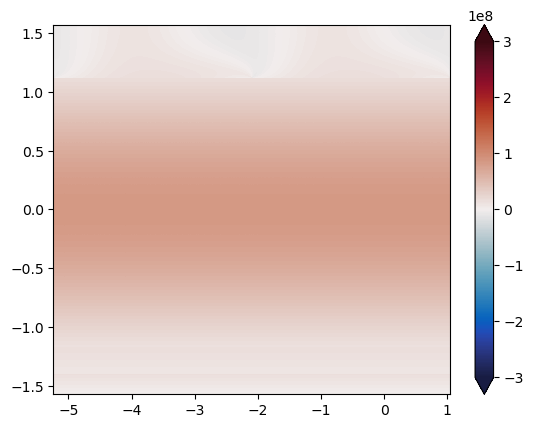

In [25]:
pcm = plt.pcolormesh(lon_z, lat_z, dA, cmap=cm.cm.balance, vmin=-3e+8, vmax=3e+8)
cb1 = plt.colorbar(pcm, orientation='vertical', extend='both')

In [26]:
ds_dissip = xr.Dataset(data_vars={
                                  "TPXO_forces": (('ny','nx'), np.array(W)),
                                  "TPXO_force1": (('ny','nx'), np.array(W1)),
                                  "TPXO_force2": (('ny','nx'), np.array(W2)),
                                  "area": (('ny','nx'), np.array(dA)),
                                 },
                       coords={"lon": (('ny', 'nx'), np.rad2deg(lon_z)), 
                               "lat": (('ny', 'nx'), np.rad2deg(lat_z))})
ds_dissip.to_netcdf('/g/data/nm03/lxy581/tpxo9v5a/TPXO_M2_W_8km.nc')

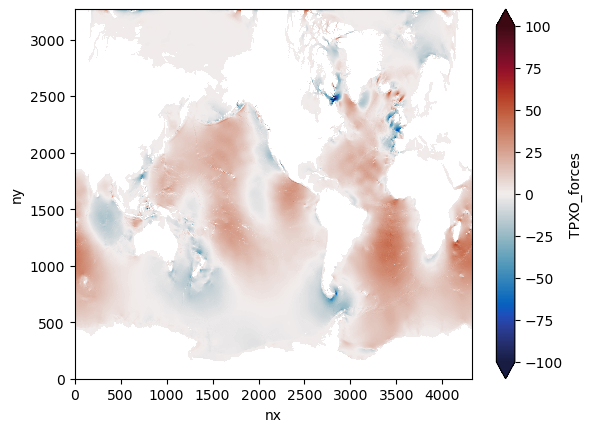

In [27]:
ds_dissip["TPXO_forces"].plot(vmin=-100,vmax=100,cmap=cm.cm.balance)

In [28]:
TPXO_forces   = np.array(ds_dissip["TPXO_forces"]) * mask_grid 
TPXO_force1   = np.array(ds_dissip["TPXO_force1"]) 
TPXO_force2   = np.array(ds_dissip["TPXO_force2"]) 

global_forces = np.nansum(TPXO_forces *dA) /1e+12 / 1e+3
global_force1 = np.nansum(TPXO_force1 *dA) /1e+12 / 1e+3
global_force2 = np.nansum(TPXO_force2 *dA) /1e+12 / 1e+3

print('Global M2 tidal energy generation: %.4fTW '%global_forces)
print('Global M2 tidal energy generation W1: %.4fTW '%global_force1)
print('Global M2 tidal energy generation W2: %.4fTW '%global_force2)

Global M2 tidal energy generation: 2.6890TW 
Global M2 tidal energy generation W1: 0.7367TW 
Global M2 tidal energy generation W2: 1.9596TW 
